# Plot the kinematic map

## Load and center the simulation snapshot

In [1]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

In [2]:
snap = "/home/michele/sim/MoRIA/sim69002/snapshot_0090"

In [3]:
s = pynbody.load(snap)

Center using the gas particles and set the galaxy 'sideon' by computing the angular momentum. Obviously the `angmom.sideon` command has a big impact on the kinematic map.

In [4]:
pynbody.analysis.halo.center(s.g, vel=False)
pynbody.analysis.angmom.sideon(s.g);

The option `vel=False` ensures that the velocities are not centered. If True, it translates velocities so that the velocity of the central 1 kpc region (default, change its radius with `cen_size`) is zeroed. One could sometimes need it.

Just to have an idea of the velocity of the center of mass of the galaxy:

In [5]:
pynbody.analysis.halo.center_of_mass_velocity(s.g)

SimArray([ 17.76761436,  -6.38041544,   5.67477703], dtype=float32, 'km s**-1')

We fix some properties of the map:

In [6]:
resolution = 1000
width = 10

## Plot the kinematic map

In practice we use our `vz` quantity as the line-of-sight velocity and we see its distribution map.

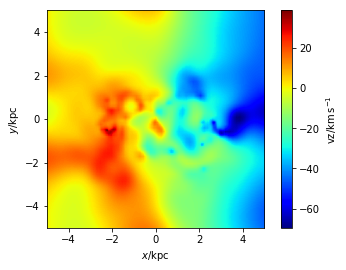

In [7]:
kinematicmap = pynbody.plot.image(s.gas, qty='vz', cmap='jet', width=width, log=False,
                                  units='km s^-1', resolution=resolution)

# Make it more realistic

## Convolve with a gaussian

To make it smoother and look more like real observations, we can convolve the image with a gaussian. `sigma` is the the dispersion of the gaussian in terms of grid size. To convert this `sigma` to a unit of length we can use the physical size of the cell. To adjust the cell sizes, modify the `resolution` argument.

We choose a sigma in kpc and we convert it in pixels.

In [8]:
sigma_kpc = 0.1

In [9]:
def kpc2pix(qty_kpc, width, resolution):
    kpc_per_pixel = width/resolution
    return int(np.floor(qty_kpc/kpc_per_pixel))

In [10]:
sigma_pix = kpc2pix(sigma_kpc, width, resolution)
sigma_pix

10

In [11]:
kinematicmap_convolved = gaussian_filter(kinematicmap, sigma_pix)

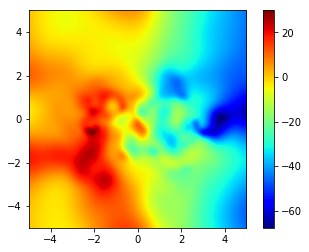

In [12]:
fig, ax = plt.subplots(1)
img = ax.imshow(kinematicmap_convolved, cmap='jet', aspect='equal',
                extent=(-width/2, width/2, -width/2, width/2), origin='lower');
fig.colorbar(img);

## Use surface density to remove some parts of the map.

Another thing to make maps more realistic is to remove (set to 0 or NaN) parts of the map where the surface density is below a certain treshold (an observationally motivated choice is 0.8 $\text{M}_\odot/\text{pc}^2$ - Verbeke, private communication).

In the following we get a surface density array

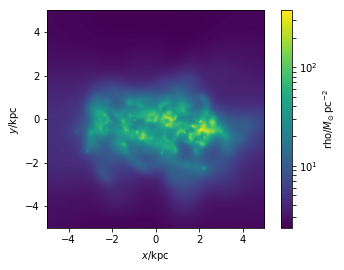

In [13]:
surfacedensity = pynbody.plot.image(s.g, width=10, resolution=resolution,
                                    units='Msol pc^-2')

In [14]:
surfacedensity.min()

SimArray(2.3503479957580566, dtype=float32, 'Msol pc**-2')

In the region we want to analyze the surface density is above the limit of 0.8 $\text{M}_\odot/\text{pc}^2$. Just to play with it we use a limit of 3 $\text{M}_\odot/\text{pc}^2$

In [15]:
# surf_dens_limit = 0.8  # Msol/pc^2"
surf_dens_limit = 3  # Msol/pc^2"

Set to 0 the line of sight velocities when the surface density is below a certain level

In [16]:
bool_filter = surfacedensity < surf_dens_limit

In [17]:
surfacedensity[bool_filter] = 0

/home/michele/Software/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


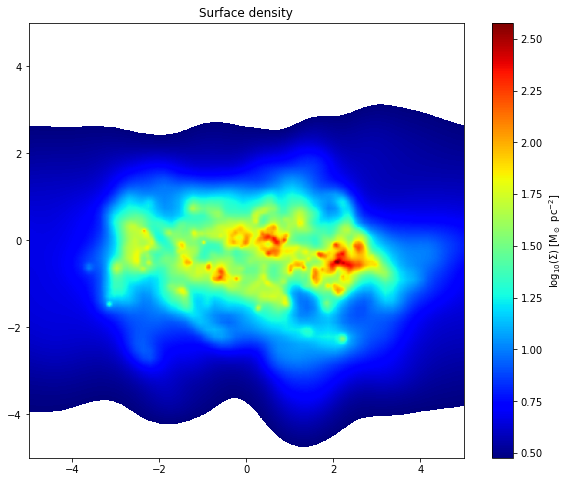

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
CS = ax.imshow(np.log10(surfacedensity), cmap='jet', aspect='equal',
               extent=(-width/2, width/2, -width/2, width/2),
               vmin=np.log10(surf_dens_limit), origin='lower')
cbar = fig.colorbar(CS, label='$\log_{10}(\Sigma)\ \mathrm{[M_\odot\ pc^{-2}]}$')
ax.set_title("Surface density");

You can see the empty region are below the `surf_dens_limit`. Beware of the logarithmic scale. We apply the same filter to  the kinematic map

In [19]:
kinematicmap[bool_filter] = np.NaN

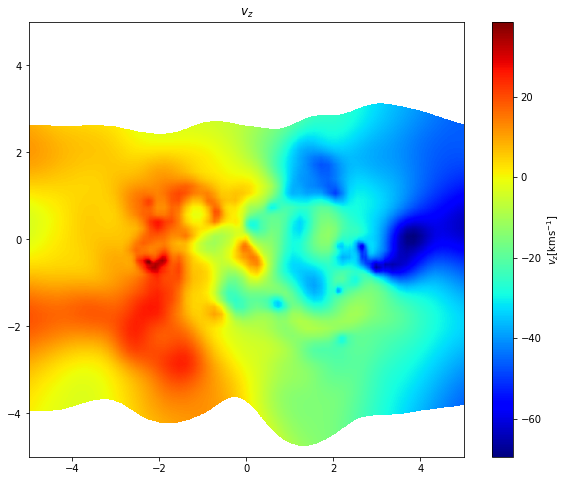

In [20]:
fig, ax = plt.subplots(1, figsize=(10,8))
km = ax.imshow(kinematicmap, cmap='jet', aspect='equal', origin='lower',
               extent=(-width/2, width/2, -width/2, width/2))
cbar = fig.colorbar(km, label='$v_z \mathrm{[km s^{-1}]}$')
ax.set_title("$v_z$");